# 1. Data Cleaning and EDA

Data = https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


In [ ]:
df = pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")

In [ ]:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [ ]:
text = df['Review']
tag = df.Rating.replace(to_replace=[1,2,3,4,5], value=[0,0,0,1,1])

In [ ]:
text

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: Review, Length: 20491, dtype: object

In [ ]:
tag

0        1
1        0
2        0
3        1
4        1
        ..
20486    1
20487    1
20488    0
20489    0
20490    0
Name: Rating, Length: 20491, dtype: int64

In [ ]:
del(df)

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 25.0 MB/s 
     |████████████████████████████████| 498.0 MB 9.1 kB/s 
     |████████████████████████████████| 1.4 MB 51.7 MB/s 
     |████████████████████████████████| 462 kB 48.0 MB/s 
     |████████████████████████████████| 5.8 MB 50.2 MB/s 


# 2. Model Creation

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

## 2.1 Load BERT Preprocessor and Encoder from Tensorflow Hub

In [3]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [4]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text_input')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='BERT_preprocessing')(text_input)
encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')(preprocessing_layer)
net = encoder['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation="sigmoid", name='Classifier')(net)

model = tf.keras.Model(text_input, net)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = "adam",
    metrics = tf.metrics.BinaryAccuracy(),
)

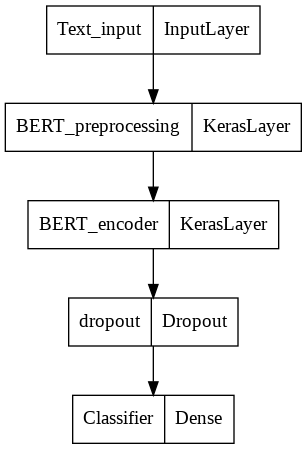

In [5]:
tf.keras.utils.plot_model(model)

# 3. Spliting data into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x, x_test, y, y_test = train_test_split(text, tag, test_size=0.2, random_state=432, shuffle=True)

# 4. Model Training 
    (validation_split=0.3)

In [ ]:
model.fit(x,y, epochs=7, batch_size=32, validation_split=0.3)

Epoch 1/7
359/359 [==============================] - 121s 338ms/step - loss: 0.3970 - binary_accuracy: 0.8256 - val_loss: 0.3666 - val_binary_accuracy: 0.8424
Epoch 2/7
359/359 [==============================] - 122s 340ms/step - loss: 0.3955 - binary_accuracy: 0.8281 - val_loss: 0.3639 - val_binary_accuracy: 0.8453
Epoch 3/7
359/359 [==============================] - 121s 336ms/step - loss: 0.3940 - binary_accuracy: 0.8239 - val_loss: 0.3633 - val_binary_accuracy: 0.8481
Epoch 4/7
359/359 [==============================] - 121s 338ms/step - loss: 0.3905 - binary_accuracy: 0.8271 - val_loss: 0.3603 - val_binary_accuracy: 0.8453
Epoch 5/7
359/359 [==============================] - 121s 336ms/step - loss: 0.3890 - binary_accuracy: 0.8296 - val_loss: 0.3576 - val_binary_accuracy: 0.8477
Epoch 6/7
359/359 [==============================] - 121s 337ms/step - loss: 0.3873 - binary_accuracy: 0.8305 - val_loss: 0.3571 - val_binary_accuracy: 0.8487
Epoch 7/7
359/359 [===========================

# After Training

    Binary Accuracy = 83%
    Validation Data Binary Accuracy = 85%

# 5. Model Evaluation

In [ ]:
model.evaluate(x_test, y_test)

129/129 [==============================] - 30s 235ms/step - loss: 0.3650 - binary_accuracy: 0.8419


[0.36499303579330444, 0.8419126868247986]

# Result on Test Data
    loss = 0.36
    binary accuract = 85%

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred

array([[0.97909945],
       [0.96171707],
       [0.9316894 ],
       ...,
       [0.6999455 ],
       [0.86254984],
       [0.4881216 ]], dtype=float32)

In [ ]:
y_pred = y_pred.flatten()
y_pred = np.where(y_pred>0.5, 1, 0)

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 0])

# 6. F1 Score and Confusion Matrix

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
f1_score(y_test, y_pred)

0.8966836734693878

### F1 Score = 0.896

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 639,  437],
       [ 211, 2812]])

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

Text(33.0, 0.5, 'Actual')

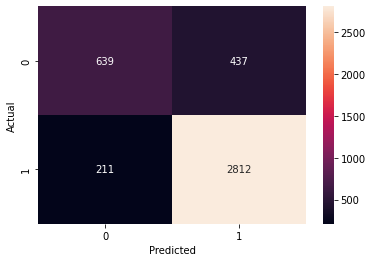

In [ ]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')